In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from joblib import Parallel, delayed

from matplotlib.font_manager import FontProperties

from simulate_radiances_utils import *
import urllib 

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [2]:
data_dir =  '/export/data2/groupMembers/cchristo/'
raw_aeri_data_dir = data_dir + 'aeri/aeri_noise_filtered/summit/'

In [3]:
file_paths = os.listdir(raw_aeri_data_dir)

In [4]:
ds_i = xr.open_dataset(raw_aeri_data_dir + file_paths[0])

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [5]:
ds_i_time = ds_i.isel(time = 0)

In [6]:
ds_i_time['mean_rad']

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.DataArray 'mean_rad' (wnum: 2714)>
array([ 94.262634, 107.40922 , 107.60945 , ...,   3.321552,   3.152382,
         3.393984], dtype=float32)
Coordinates:
  * wnum     (wnum) float32 491.79016 492.2723 492.75446 ... 1799.3734 1799.8556
    time     datetime64[ns] 2010-06-28T02:54:25
Attributes:
    longname:   Interferometer scan directional average of radiance
    units:      mw/(m2 sr cm-1)
    precision:  1E4

In [7]:
# radiance_unit_conv = (1e-3)*
ds_i_time


<xarray.Dataset>
Dimensions:                                  (wnum: 2714, wnum2: 151)
Coordinates:
  * wnum                                     (wnum) float32 491.79016 ... 1799.8556
    time                                     datetime64[ns] 2010-06-28T02:54:25
  * wnum2                                    (wnum2) float32 800.0 ... 1400.0
Data variables:
    date                                     int32 ...
    base_time                                datetime64[ns] ...
    time_offset                              datetime64[ns] ...
    missingDataFlag                          float32 ...
    sceneMirPosEncoderMaxDrift               float32 ...
    BBcavityFactor                           float32 ...
    HBBtempOffset                            float32 ...
    ABBtempOffset                            float32 ...
    HBBbottomTempWeight                      float32 ...
    HBBapexTempWeight                        float32 ...
    HBBtopTempWeight                         float32 ...
    ABBbottomTempWeight                      float32 ...
    ABBapexTempWeight                        float32 ...
    ABBtopTempWeight                         float32 ...
    calibratedSceneID                        float32 ...
    calibrationHBBtemp                       float32 ...
    calibrationCBBtemp                       float32 ...
    calibrationAmbientTemp                   float32 ...
    channelNumber                            float32 ...
    sceneMirPosEncoderDrift                  float32 ...
    HBBmaxTempDiff                           float32 ...
    ABBmaxTempDiff                           float32 ...
    maxRoll                                  float32 ...
    maxPitch                                 float32 ...
    opticsCompartmentRelativeHumidity        float32 ...
    sceneMirrorMotorStep                     float32 ...
    sceneMirrorAngle                         float32 ...
    maxSampleStdDev                          float32 ...
    atmosphericPressure                      float32 ...
    interferometerEnclosureRelativeHumidity  float32 ...
    atmosphericRelativeHumidity              float32 ...
    interferometerWindowTemp                 float32 ...
    rainSensorIntensity                      float32 ...
    detectorTemp                             float32 ...
    coolerCurrent                            float32 ...
    SCEtemp                                  float32 ...
    motorDriverTemp                          float32 ...
    computerTemp                             float32 ...
    rackAmbientTemp                          float32 ...
    coolerPowerSupplyTemp                    float32 ...
    coolerExpanderTemp                       float32 ...
    coolerCompressorTemp                     float32 ...
    BBcontroller2temp                        float32 ...
    BBcontroller1temp                        float32 ...
    fixed12KohmResistor                      float32 ...
    mirrorMotorTemp                          float32 ...
    airNearBBsTemp                           float32 ...
    BBsupportStructureTemp                   float32 ...
    interferometerSecondPortTemp             float32 ...
    airNearInterferometerTemp                float32 ...
    outsideAirTemp                           float32 ...
    fixed97KohmResistor                      float32 ...
    fixed2500ohmResistor                     float32 ...
    HBBbottomTemp                            float32 ...
    HBBapexTemp                              float32 ...
    HBBtopTemp                               float32 ...
    ABBbottomTemp                            float32 ...
    ABBapexTemp                              float32 ...
    ABBtopTemp                               float32 ...
    JulianDay                                timedelta64[ns] ...
    sceneMirPosEncoder                       float32 ...
    sceneMirPosCount                         float32 ...
    sceneMirrorPosition                      float32 ...
    coadditionsCount           

In [9]:
# radiance_conv
k_grid.min()
# k_grid.max()

NameError: name 'k_grid' is not defined

Text(0, 0.5, 'Radiance')

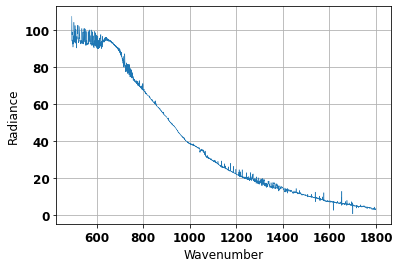

In [10]:
# ds_i
k_grid = ds_i_time['wnum'].values
rad = ds_i_time['mean_rad'].values
plt.plot(k_grid, rad, linewidth = 0.5)
plt.grid()
plt.xlabel('Wavenumber')
plt.ylabel('Radiance')

In [24]:
standard_dev_rad = ds_i_time['standard_dev_mean_rad'].values
k_grid2 = ds_i_time['wnum2'].values

Text(0, 0.5, 'Radiance STD')

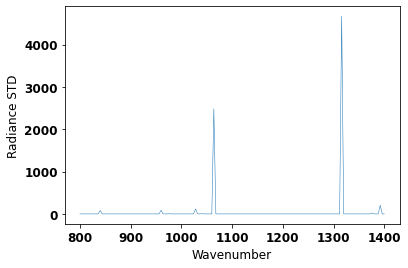

In [25]:
plt.plot(k_grid2, standard_dev_rad, linewidth = 0.5)

plt.xlabel('Wavenumber')
plt.ylabel('Radiance STD')